In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
!gdown --id '1sOZzNoM-IIWORcUGOlJV_3MyRCgAayd3' --output level-6.csv

Downloading...
From: https://drive.google.com/uc?id=1sOZzNoM-IIWORcUGOlJV_3MyRCgAayd3
To: /content/level-6.csv
100% 278k/278k [00:00<00:00, 37.5MB/s]


In [ ]:
train = pd.read_csv("level-6.csv")
train.head()

,index,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;Blastocatella,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;__,Bacteria;Acidobacteriota;Blastocatellia;Pyrinomonadales;Pyrinomonadaceae;RB41,Bacteria;Actinobacteriota;Acidimicrobiia;Actinomarinales;uncultured;__,Bacteria;Actinobacteriota;Actinobacteria;Actinomycetales;Actinomycetaceae;Actinomyces,Bacteria;Actinobacteriota;Actinobacteria;Actinomycetales;Actinomycetaceae;Arcanobacterium,Bacteria;Actinobacteriota;Actinobacteria;Actinomycetales;Actinomycetaceae;Varibaculum,Bacteria;Actinobacteriota;Actinobacteria;Actinomycetales;Actinomycetaceae;__,Bacteria;Actinobacteriota;Actinobacteria;Bifidobacteriales;Bifidobacteriaceae;Alloscardovia,Bacteria;Actinobacteriota;Actinobacteria;Bifidobacteriales;Bifidobacteriaceae;Bifidobacterium,Bacteria;Actinobacteriota;Actinobacteria;Bifidobacteriales;Bifidobacteriaceae;Gardnerella,Bacteria;Actinobacteriota;Actinobacteria;Corynebacteriales;Corynebacteriaceae;Corynebacterium,Bacteria;Actinobacteriota;Actinobacteria;Corynebacteriales;Corynebacteriaceae;Lawsonella,Bacteria;Actinobacteriota;Actinobacteria;Corynebacteriales;Corynebacteriaceae;Turicella,Bacteria;Actinobacteriota;Actinobacteria;Corynebacteriales;Mycobacteriaceae;Mycobacterium,Bacteria;Actinobacteriota;Actinobacteria;Corynebacteriales;Nocardiaceae;Rhodococcus,Bacteria;Actinobacteriota;Actinobacteria;Frankiales;Geodermatophilaceae;__,Bacteria;Actinobacteriota;Actinobacteria;Frankiales;Sporichthyaceae;hgcI_clade,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Brevibacteriaceae;Brevibacterium,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Intrasporangiaceae;Arsenicicoccus,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Intrasporangiaceae;Ornithinimicrobium,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Intrasporangiaceae;Tetrasphaera,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Intrasporangiaceae;__,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Microbacteriaceae;__,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Micrococcaceae;Arthrobacter,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Micrococcaceae;Kocuria,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Micrococcaceae;Micrococcus,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Micrococcaceae;Nesterenkonia,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Micrococcaceae;Rothia,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Micrococcaceae;__,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;__;__,Bacteria;Actinobacteriota;Actinobacteria;Micromonosporales;Micromonosporaceae;__,Bacteria;Actinobacteriota;Actinobacteria;Propionibacteriales;Propionibacteriaceae;Cutibacterium,Bacteria;Actinobacteriota;Actinobacteria;__;__;__,Bacteria;Actinobacteriota;Coriobacteriia;Coriobacteriales;Atopobiaceae;Atopobium,Bacteria;Actinobacteriota;Coriobacteriia;Coriobacteriales;Atopobiaceae;Coriobacteriaceae_UCG-003,Bacteria;Actinobacteriota;Coriobacteriia;Coriobacteriales;Atopobiaceae;Olsenella,Bacteria;Actinobacteriota;Coriobacteriia;Coriobacteriales;Eggerthellaceae;Slackia,Bacteria;Actinobacteriota;Rubrobacteria;Rubrobacterales;Rubrobacteriaceae;Rubrobacter,...,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Neisseriaceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Neisseriaceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Oxalobacteraceae;Herbaspirillum,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Oxalobacteraceae;Massilia,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Rhodocyclaceae;Methyloversatilis,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Rhodocyclaceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Cardiobacteriales;Cardiobacteriaceae;Suttonella,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Enterobacteriaceae;Citrobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;E

In [ ]:
# shortrun = train[train['Merged'] < 920].index
# train = train.drop(shortrun,axis=0)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Columns: 298 entries, index to Cancer
dtypes: float64(295), int64(1), object(2)
memory usage: 677.6+ KB


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Columns: 298 entries, index to Cancer
dtypes: float64(295), int64(1), object(2)
memory usage: 677.6+ KB


In [ ]:
CAT_COL = ["index", "Cancer"]

NUM_COL=[]
for i in range(len(train.columns)):
  NUM_COL.append(train.columns[i])
NUM_COL.remove('index')
NUM_COL.remove('Cancer')

cat_col = []
num_col = []
for col in train:
  if col in CAT_COL:
    cat_col.append(col)
  elif col in NUM_COL:
    num_col.append(col)
for col in cat_col:
  train[col] = train[col].astype(str)

df_cat = train.loc[:,cat_col] # take all the categorical columns
df_cat = pd.get_dummies(df_cat) # one hot encoding

df_num = train.loc[:,num_col] # take all the numerical columns
df_final = pd.concat([df_cat, df_num], axis=1) # concat categorical/numerical data

In [ ]:
df_final.head()

,index_SRR3991006,index_SRR3991007,index_SRR3991008,index_SRR3991009,index_SRR3991010,index_SRR3991011,index_SRR3991012,index_SRR3991013,index_SRR3991014,index_SRR3991015,index_SRR3991016,index_SRR3991017,index_SRR3991018,index_SRR3991019,index_SRR3991020,index_SRR3991021,index_SRR3991022,index_SRR3991023,index_SRR3991024,index_SRR3991025,index_SRR3991026,index_SRR3991027,index_SRR3991028,index_SRR3991029,index_SRR3991030,index_SRR3991031,index_SRR3991032,index_SRR3991033,index_SRR3991034,index_SRR3991035,index_SRR3991036,index_SRR3991037,index_SRR3991038,index_SRR3991039,index_SRR3991040,index_SRR3991041,index_SRR3991042,index_SRR3991043,index_SRR3991044,index_SRR3991045,...,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Neisseriaceae;Neisseria,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Neisseriaceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Neisseriaceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Oxalobacteraceae;Herbaspirillum,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Oxalobacteraceae;Massilia,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Rhodocyclaceae;Methyloversatilis,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Rhodocyclaceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Cardiobacteriales;Cardiobacteriaceae;Suttonella,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Enterobacteriaceae;Citrobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Enterobacteriaceae;Enterobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Enterobacteriaceae;Escherichia-Shigella,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Enterobacteriaceae;Klebsiella,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Enterobacteriaceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Yersiniaceae;Serratia,Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;__;__,Bacteria;Proteobacteria;Gammaproteobacteria;Pasteurellales;Pasteurellaceae;Actinobacillus,Bacteria;Proteobacteria;Gammaproteobacteria;Pasteurellales;Pasteurellaceae;Aggregatibacter,Bacteria;Proteobacteria;Gammaproteobacteria;Pasteurellales;Pasteurellaceae;Haemophilus,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Acinetobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Enhydrobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Moraxella,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Moraxellaceae;Psychrobacter,Bacteria;Proteobacteria;Gammaproteobacteria;Pseudomonadales;Pseudomonadaceae;Pseudomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Pseudoxanthomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Stenotrophomonas,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Vulcaniibacterium,Bacteria;Proteobacteria;Gammaproteobacteria;Xanthomonadales;Xanthomonadaceae;Xanthomonas,Bacteria;Proteobacteria;Gammaproteobacteria;__;__;__,Bacteria;Proteobacteria;__;__;__;__,Bacteria;Saccharibacteria_TM7;Saccharimonas;Saccharimonas;PAC000016;AY792306,Bacteria;Spirochaetota;Spirochaetia;Spirochaetales;Spirochaetaceae;Treponema,Bacteria;Synergistota;Synergistia;Synergistales;Synergistaceae;Fretibacterium,Bacteria;Synergistota;Synergistia;Synergistales;Synergistaceae;Pyramidobacter,Bacteria;Verrucomicrobia;Kiritimatiellae;EF436358;EF436358;EF436358,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Chthoniobacterales;Chthoniobacteraceae;Chthoniobacter,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Verrucomicrobiales;Akkermansiaceae;Akkermansia,Bacteria;Verrucomicrobiota;Verrucomicrobiae;Verrucomicrobiales;Verrucomicrobiaceae;Verrucomicrobium,Bacteria;__;__;__;__;__,Unassigned;__;__;__;__;__,Merged
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.000000,0.012908,0.0,0.0,0.

In [ ]:
not_select = ["index", "Cancer", "Merged"]
train_select = train.drop(not_select,axis=1)
train_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Columns: 295 entries, Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;Blastocatella to Unassigned;__;__;__;__;__
dtypes: float64(295)
memory usage: 670.8 KB


In [ ]:
cat_col = []
num_col = []
for col in train_select:
  if col in CAT_COL:
    cat_col.append(col)
  elif col in NUM_COL:
    num_col.append(col)

for col in cat_col:
  if train_select[col].dtype != "O":
    # print(col)
    train_select[col] = train_select[col].astype(str)

df_cat_select = train_select.loc[:,cat_col] # take all the categorical columns
#df_cat_select = pd.get_dummies(df_cat_select) # one hot encoding

df_num_select = train_select.loc[:,num_col] # take all the numerical columns
df_final_select = pd.concat([df_cat_select, df_num_select], axis=1) # concat categorical/numerical data

In [ ]:
df_final_select.head()

,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;Blastocatella,Bacteria;Acidobacteriota;Blastocatellia;Blastocatellales;Blastocatellaceae;__,Bacteria;Acidobacteriota;Blastocatellia;Pyrinomonadales;Pyrinomonadaceae;RB41,Bacteria;Actinobacteriota;Acidimicrobiia;Actinomarinales;uncultured;__,Bacteria;Actinobacteriota;Actinobacteria;Actinomycetales;Actinomycetaceae;Actinomyces,Bacteria;Actinobacteriota;Actinobacteria;Actinomycetales;Actinomycetaceae;Arcanobacterium,Bacteria;Actinobacteriota;Actinobacteria;Actinomycetales;Actinomycetaceae;Varibaculum,Bacteria;Actinobacteriota;Actinobacteria;Actinomycetales;Actinomycetaceae;__,Bacteria;Actinobacteriota;Actinobacteria;Bifidobacteriales;Bifidobacteriaceae;Alloscardovia,Bacteria;Actinobacteriota;Actinobacteria;Bifidobacteriales;Bifidobacteriaceae;Bifidobacterium,Bacteria;Actinobacteriota;Actinobacteria;Bifidobacteriales;Bifidobacteriaceae;Gardnerella,Bacteria;Actinobacteriota;Actinobacteria;Corynebacteriales;Corynebacteriaceae;Corynebacterium,Bacteria;Actinobacteriota;Actinobacteria;Corynebacteriales;Corynebacteriaceae;Lawsonella,Bacteria;Actinobacteriota;Actinobacteria;Corynebacteriales;Corynebacteriaceae;Turicella,Bacteria;Actinobacteriota;Actinobacteria;Corynebacteriales;Mycobacteriaceae;Mycobacterium,Bacteria;Actinobacteriota;Actinobacteria;Corynebacteriales;Nocardiaceae;Rhodococcus,Bacteria;Actinobacteriota;Actinobacteria;Frankiales;Geodermatophilaceae;__,Bacteria;Actinobacteriota;Actinobacteria;Frankiales;Sporichthyaceae;hgcI_clade,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Brevibacteriaceae;Brevibacterium,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Intrasporangiaceae;Arsenicicoccus,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Intrasporangiaceae;Ornithinimicrobium,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Intrasporangiaceae;Tetrasphaera,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Intrasporangiaceae;__,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Microbacteriaceae;__,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Micrococcaceae;Arthrobacter,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Micrococcaceae;Kocuria,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Micrococcaceae;Micrococcus,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Micrococcaceae;Nesterenkonia,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Micrococcaceae;Rothia,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;Micrococcaceae;__,Bacteria;Actinobacteriota;Actinobacteria;Micrococcales;__;__,Bacteria;Actinobacteriota;Actinobacteria;Micromonosporales;Micromonosporaceae;__,Bacteria;Actinobacteriota;Actinobacteria;Propionibacteriales;Propionibacteriaceae;Cutibacterium,Bacteria;Actinobacteriota;Actinobacteria;__;__;__,Bacteria;Actinobacteriota;Coriobacteriia;Coriobacteriales;Atopobiaceae;Atopobium,Bacteria;Actinobacteriota;Coriobacteriia;Coriobacteriales;Atopobiaceae;Coriobacteriaceae_UCG-003,Bacteria;Actinobacteriota;Coriobacteriia;Coriobacteriales;Atopobiaceae;Olsenella,Bacteria;Actinobacteriota;Coriobacteriia;Coriobacteriales;Eggerthellaceae;Slackia,Bacteria;Actinobacteriota;Rubrobacteria;Rubrobacterales;Rubrobacteriaceae;Rubrobacter,Bacteria;Aquificota;Aquificae;Aquificales;Aquificaceae;Hydrogenobacter,...,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Neisseriaceae;Eikenella,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Neisseriaceae;Neisseria,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Neisseriaceae;__,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Neisseriaceae;uncultured,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Oxalobacteraceae;Herbaspirillum,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Oxalobacteraceae;Massilia,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Rhodocyclaceae;Methyloversatilis,Bacteria;Proteobacteria;Gammaproteobacteria;Burkholderiales;Rhodocyclaceae;__,Bacteria;Prot

#DNN

In [ ]:
import os
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
os.environ['TF_CPP_MIN_LOG_LEVEL']= '2'

In [ ]:
target_var = 'Cancer'
features = list(df_final_select.columns)
# 目標變量的類別
Class = train[target_var].unique()
# 目標變量的類別字典
Class_dict = dict(zip(Class, range(len(Class))))
# 增加一列target, 將目標變量進行編碼
train['target'] = train[target_var].apply(lambda x: Class_dict[x])
# 對目標變量進行0-1編碼(One-hot Encoding)
lb = LabelBinarizer()
lb.fit(list(Class_dict.values()))
transformed_labels = lb.transform(train['target'])
label2 = np.zeros((291,1))

for i in range(len(transformed_labels)):
  if transformed_labels[i][0] == 0:
    label2[i][0] = np.int(1)
  elif transformed_labels[i][0] == 1:
    label2[i][0] = np.int(0)

transformed_labels = np.concatenate((transformed_labels, label2),axis=1)

y_bin_labels = []  # 對多分類進行0-1編碼的變量
for i in range(transformed_labels.shape[1]):
    y_bin_labels.append( 'y' + str(i))
    train['y' + str(i)] = transformed_labels[:, i]
# 將數據集分為訓練集和測試集
train_x, test_x, train_y, test_y = train_test_split(df_final_select[features], train[y_bin_labels], train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
np.random.seed(5)
# model
init = K.initializers.glorot_uniform(seed=1)
model = K.models.Sequential()
model.add(K.layers.Dense(units=80, input_dim=295, kernel_initializer=init, activation='relu'))
model.add(K.layers.Dense(units=2, kernel_initializer=init, activation='relu'))

In [ ]:
# 訓練模型
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy',
        metrics=['accuracy'])

h = model.fit(train_x, train_y, epochs=50, batch_size=4,
      validation_data=(test_x, test_y))

Epoch 1/50
58/58 [==============================] - 1s 9ms/step - loss: nan - accuracy: 0.4267 - val_loss: nan - val_accuracy: 0.4576
Epoch 2/50
58/58 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.5862 - val_loss: 0.6851 - val_accuracy: 0.6102
Epoch 3/50
58/58 [==============================] - 0s 3ms/step - loss: 0.6801 - accuracy: 0.6810 - val_loss: 0.6784 - val_accuracy: 0.6441
Epoch 4/50
58/58 [==============================] - 0s 4ms/step - loss: 0.6453 - accuracy: 0.6940 - val_loss: 0.9170 - val_accuracy: 0.6271
Epoch 5/50
58/58 [==============================] - 0s 3ms/step - loss: 0.6104 - accuracy: 0.7284 - val_loss: nan - val_accuracy: 0.5763
Epoch 6/50
58/58 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.7284 - val_loss: nan - val_accuracy: 0.5763
Epoch 7/50
58/58 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.7328 - val_loss: nan - val_accuracy: 0.5763
Epoch 8/50
58/58 [==========================

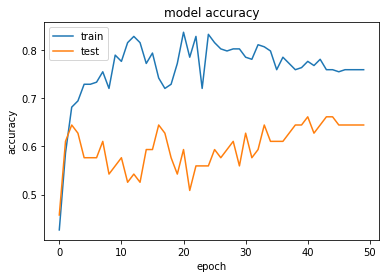

In [ ]:
# summarize history for accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#PH-CNN
##reference:
###https://github.com/dfioravanti/phylogenetic-cnn
###https://www.tensorflow.org/tutorials/images/cnn

In [ ]:
import os
from tensorflow.keras import datasets, layers, models

##Import coordinate data

In [ ]:
#reshape
!gdown --id '1F4ZRd7dGmq-T_YDryOxvuilVWThoxsnZ' --output ordinate.csv
C = pd.read_csv("ordinate.csv")
# Xs = df_final_select.values

Downloading...
From: https://drive.google.com/uc?id=1F4ZRd7dGmq-T_YDryOxvuilVWThoxsnZ
To: /content/ordinate.csv
100% 312k/312k [00:00<00:00, 41.5MB/s]


In [ ]:
# C = C.drop(shortrun,axis=0)
C.head()

,index,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,Merged,Cancer
0,SRR3991006,0.571480,0.003426,0.084577,0.218201,-0.085818,0.062822,0.127338,-0.032965,-0.054515,0.046297,-0.022930,-0.016357,-0.010015,-0.015553,-0.034868,-0.007039,0.115902,0.034346,-0.040809,0.037904,0.030447,0.042842,0.018650,0.003225,0.045977,-0.000910,0.065165,0.002502,-0.015011,-0.007993,0.036780,-0.053604,0.004146,-0.014230,0.010731,0.069508,0.028478,-0.001543,0.049154,...,-0.005124,-0.006486,-0.004460,-0.004722,-0.003478,-0.019204,0.008081,0.021545,-0.003555,0.020889,0.005948,-0.009456,0.010962,-0.015993,0.011302,-0.002339,0.003995,-0.003551,-0.001138,-0.001694,-0.006838,-0.003076,-0.018441,0.004615,0.007357,-0.001924,-0.005096,0.004102,0.007485,0.003813,-0.001005,0.006767,-0.000083,-0.002974,-0.003308,-0.002256,0.001291,-0.001338,2634,non-cancer
1,SRR3991007,0.312141,0.042906,-0.074462,-0.126234,0.066583,0.079203,-0.049716,0.005663,-0.034120,0.003355,0.125155,0.097222,0.128088,0.003928,-0.051895,0.057999,0.030351,-0.013088,0.022290,-0.078366,-0.022503,0.028706,-0.006228,-0.019000,-0.081004,0.068575,0.058510,-0.035880,0.029271,0.020630,0.011218,-0.039325,0.037984,0.046480,-0.026434,-0.028761,0.048572,-0.113133,-0.041216,...,-0.056600,0.001405,-0.018780,0.020089,-0.016934,-0.017534,-0.011708,0.031395,-0.000066,0.000057,-0.011799,-0.013033,0.046107,0.022562,-0.004941,0.012137,0.005452,-0.023110,0.002507,0.001269,-0.002902,0.000350,0.011722,0.005239,-0.001719,0.003079,-0.002756,-0.002012,0.001176,0.002436,-0.000016,-0.000137,0.001977,-0.002506,0.000300,0.000377,-0.000613,0.002213,1839,cancer
2,SRR3991008,-0.300355,-0.637216,0.085563,-0.240529,0.250263,-0.065490,0.118430,-0.216430,0.002108,0.129218,-0.010558,-0.120006,0.088440,-0.045816,-0.023422,-0.021940,0.004224,0.071036,0.035829,0.031353,0.043460,0.042312,0.007926,-0.029428,-0.051457,0.001690,-0.000278,-0.021913,-0.009188,0.019242,-0.013340,-0.008236,-0.007204,-0.001976,0.028796,-0.002705,0.015095,0.020570,-0.022503,...,-0.008107,0.000154,0.010280,-0.007794,-0.005874,0.002875,-0.001343,-0.001690,-0.000678,0.010312,-0.005319,-0.000785,0.000756,-0.000182,0.008385,-0.007491,-0.012022,-0.008305,-0.000823,0.004452,-0.000006,-0.005307,0.003608,-0.004351,0.000542,0.011394,0.004304,-0.010499,-0.005888,-0.013368,-0.005021,0.007659,-0.011148,-0.004118,-0.003170,0.005576,0.009315,-0.005472,5166,non-cancer
3,SRR3991009,-0.514976,0.446194,-0.045839,-0.012054,-0.131128,0.047576,-0.018848,0.011476,0.050099,0.042583,-0.012691,-0.037744,-0.096069,-0.060894,-0.115322,0.016426,-0.017488,0.050397,0.001569,0.013965,-0.008737,0.002082,0.020673,-0.046805,0.000629,0.031647,-0.029707,0.012063,0.029881,-0.023031,-0.000416,0.025433,0.072571,0.002156,-0.040004,0.016282,-0.012467,-0.027556,0.023336,...,0.014710,0.008867,-0.007722,-0.009297,-0.016074,0.021467,-0.000081,-0.006636,-0.002463,0.039386,0.005784,-0.007084,0.018080,0.001243,0.000333,-0.016167,0.002281,-0.018663,-0.003997,-0.012681,0.010099,0.014944,0.009900,-0.016656,0.001846,-0.006695,0.009241,0.003214,0.001127,0.000268,0.000774,0.002727,-0.002102,0.002447,-0.000503,-0.002396,0.000906,-0.001723,5558,non-cancer
4,SRR3991010,-0.156919,-0.340404,0.028644,-0.120975,0.040047,0.150411,0.075815,0.037537,-0.036883,-0.102902,-0.020334,0.022985,0.012745,0.075820,-0.036302,-0.014148,0.003566,0.023311,-0.087022,-0.003600,-0.094889,-0.011213,-0.023667,-0.037857,-0.008153,-0.032433,0.009153,-0.029447,0.000942,0.066188,-0.048481,-0.007039,-0.008181,-0.101616,0.056654,0.016389,0.006423,-0.001833,-0.000494,...,-0.013994,0.012421,-0.010482,-0.010114,-0.024761,-0.000135,-0.011794,-0.003513,0.005969,0.023268,0.009465,0.004824,0.005045,-0.015564,-0.006950,-0.009948,-0.012319,-0.000793,0.019170,0.023245,-0.003589,-0.001555,-0.011992,-0.002755,0.000817,0.007927,0.000470,-0.010149,-0.005697,0.007402,-0.002092,-0.00216

In [ ]:
not_select=['index', 'Merged','Cancer']
C_final = C.drop(not_select,axis=1)
C_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 85 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       291 non-null    float64
 1   2       291 non-null    float64
 2   3       291 non-null    float64
 3   4       291 non-null    float64
 4   5       291 non-null    float64
 5   6       291 non-null    float64
 6   7       291 non-null    float64
 7   8       291 non-null    float64
 8   9       291 non-null    float64
 9   10      291 non-null    float64
 10  11      291 non-null    float64
 11  12      291 non-null    float64
 12  13      291 non-null    float64
 13  14      291 non-null    float64
 14  15      291 non-null    float64
 15  16      291 non-null    float64
 16  17      291 non-null    float64
 17  18      291 non-null    float64
 18  19      291 non-null    float64
 19  20      291 non-null    float64
 20  21      291 non-null    float64
 21  22      291 non-null    float64
 22  23

In [ ]:
C_final.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85
0,0.571480,0.003426,0.084577,0.218201,-0.085818,0.062822,0.127338,-0.032965,-0.054515,0.046297,-0.022930,-0.016357,-0.010015,-0.015553,-0.034868,-0.007039,0.115902,0.034346,-0.040809,0.037904,0.030447,0.042842,0.018650,0.003225,0.045977,-0.000910,0.065165,0.002502,-0.015011,-0.007993,0.036780,-0.053604,0.004146,-0.014230,0.010731,0.069508,0.028478,-0.001543,0.049154,0.037767,...,-0.005174,-0.006677,-0.005124,-0.006486,-0.004460,-0.004722,-0.003478,-0.019204,0.008081,0.021545,-0.003555,0.020889,0.005948,-0.009456,0.010962,-0.015993,0.011302,-0.002339,0.003995,-0.003551,-0.001138,-0.001694,-0.006838,-0.003076,-0.018441,0.004615,0.007357,-0.001924,-0.005096,0.004102,0.007485,0.003813,-0.001005,0.006767,-0.000083,-0.002974,-0.003308,-0.002256,0.001291,-0.001338
1,0.312141,0.042906,-0.074462,-0.126234,0.066583,0.079203,-0.049716,0.005663,-0.034120,0.003355,0.125155,0.097222,0.128088,0.003928,-0.051895,0.057999,0.030351,-0.013088,0.022290,-0.078366,-0.022503,0.028706,-0.006228,-0.019000,-0.081004,0.068575,0.058510,-0.035880,0.029271,0.020630,0.011218,-0.039325,0.037984,0.046480,-0.026434,-0.028761,0.048572,-0.113133,-0.041216,0.007006,...,0.011831,0.010258,-0.056600,0.001405,-0.018780,0.020089,-0.016934,-0.017534,-0.011708,0.031395,-0.000066,0.000057,-0.011799,-0.013033,0.046107,0.022562,-0.004941,0.012137,0.005452,-0.023110,0.002507,0.001269,-0.002902,0.000350,0.011722,0.005239,-0.001719,0.003079,-0.002756,-0.002012,0.001176,0.002436,-0.000016,-0.000137,0.001977,-0.002506,0.000300,0.000377,-0.000613,0.002213
2,-0.300355,-0.637216,0.085563,-0.240529,0.250263,-0.065490,0.118430,-0.216430,0.002108,0.129218,-0.010558,-0.120006,0.088440,-0.045816,-0.023422,-0.021940,0.004224,0.071036,0.035829,0.031353,0.043460,0.042312,0.007926,-0.029428,-0.051457,0.001690,-0.000278,-0.021913,-0.009188,0.019242,-0.013340,-0.008236,-0.007204,-0.001976,0.028796,-0.002705,0.015095,0.020570,-0.022503,-0.007846,...,0.000699,-0.010534,-0.008107,0.000154,0.010280,-0.007794,-0.005874,0.002875,-0.001343,-0.001690,-0.000678,0.010312,-0.005319,-0.000785,0.000756,-0.000182,0.008385,-0.007491,-0.012022,-0.008305,-0.000823,0.004452,-0.000006,-0.005307,0.003608,-0.004351,0.000542,0.011394,0.004304,-0.010499,-0.005888,-0.013368,-0.005021,0.007659,-0.011148,-0.004118,-0.003170,0.005576,0.009315,-0.005472
3,-0.514976,0.446194,-0.045839,-0.012054,-0.131128,0.047576,-0.018848,0.011476,0.050099,0.042583,-0.012691,-0.037744,-0.096069,-0.060894,-0.115322,0.016426,-0.017488,0.050397,0.001569,0.013965,-0.008737,0.002082,0.020673,-0.046805,0.000629,0.031647,-0.029707,0.012063,0.029881,-0.023031,-0.000416,0.025433,0.072571,0.002156,-0.040004,0.016282,-0.012467,-0.027556,0.023336,-0.003035,...,0.023335,-0.027145,0.014710,0.008867,-0.007722,-0.009297,-0.016074,0.021467,-0.000081,-0.006636,-0.002463,0.039386,0.005784,-0.007084,0.018080,0.001243,0.000333,-0.016167,0.002281,-0.018663,-0.003997,-0.012681,0.010099,0.014944,0.009900,-0.016656,0.001846,-0.006695,0.009241,0.003214,0.001127,0.000268,0.000774,0.002727,-0.002102,0.002447,-0.000503,-0.002396,0.000906,-0.001723
4,-0.156919,-0.340404,0.028644,-0.120975,0.040047,0.150411,0.075815,0.037537,-0.036883,-0.102902,-0.020334,0.022985,0.012745,0.075820,-0.036302,-0.014148,0.003566,0.023311,-0.087022,-0.003600,-0.094889,-0.011213,-0.023667,-0.037857,-0.008153,-0.032433,0.009153,-0.029447,0.000942,0.066188,-0.048481,-0.007039,-0.008181,-0.101616,0.056654,0.016389,0.006423,-0.001833,-0.000494,-0.023733,...,-0.010619,0.005044,-0.013994,0.012421,-0.010482,-0.010114,-0.024761,-0.000135,-0.011794,-0.003513,0.005969,0.023268,0.009465,0.004824,0.005045,-0.015564,-0.006950,-0.009948,-0.012319,-0.000793,0.019170,0.023245,-0.003589,-0.001555,-0.011992,-0.002755,0.000817,0.007927,0.000470,-0.010149,-0.005697,0.007402,-

In [ ]:
X_final = pd.concat([df_final_select, C_final], axis=1)
X_final.shape

(291, 380)

In [ ]:
target_var = 'Cancer'
features = list(X_final.columns)
# 目標變量的類別
Class = train[target_var].unique()
# 目標變量的類別字典
Class_dict = dict(zip(Class, range(len(Class))))
# 增加一列target, 將目標變量進行編碼
train['target'] = train[target_var].apply(lambda x: Class_dict[x])
# 對目標變量進行0-1編碼(One-hot Encoding)
lb = LabelBinarizer()
lb.fit(list(Class_dict.values()))
transformed_labels = lb.transform(train['target'])
label2 = np.zeros((291,1))

for i in range(len(transformed_labels)):
  if transformed_labels[i][0] == 0:
    label2[i][0] = np.int(1)
  elif transformed_labels[i][0] == 1:
    label2[i][0] = np.int(0)

transformed_labels = np.concatenate((transformed_labels, label2),axis=1)

y_bin_labels = []  # 對多分類進行0-1編碼的變量
for i in range(transformed_labels.shape[1]):
    y_bin_labels.append( 'y' + str(i))
    train['y' + str(i)] = transformed_labels[:, i]
# 將數據集分為訓練集和測試集
train_x, test_x, train_y, test_y = train_test_split(X_final[features], train[y_bin_labels], train_size=0.8, test_size=0.2, random_state=0)

In [ ]:
print(train_x.shape)
print(test_x.shape)

(232, 380)
(59, 380)


In [ ]:
# train_x = train_x.values.reshape(232, 2, 2, 95)
train_x = train_x.reshape(232, 2, 2, 95)
# test_x = test_x.values.reshape(59, 2, 2, 95)
test_x = test_x.reshape(59, 2, 2, 95)

## Model(Same as paper)

In [ ]:
model = K.models.Sequential()
model.add(K.layers.Conv2D(95, (1, 1), activation='relu', input_shape=train_x.shape[1:]))
model.add(K.layers.Conv2D(50, (1, 1), activation='relu', input_shape=train_x.shape[1:]))
model.add(K.layers.MaxPooling2D((2, 2)))
model.add(K.layers.Flatten())
model.add(K.layers.Dense(64, activation= 'relu'))
model.add(K.layers.Dropout(0.25))
model.add(K.layers.Dense(2,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 2, 2, 95)          9120      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 2, 50)          4800      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 50)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                3264      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 2)               

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
# opt = K.optimizers.Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy',
        metrics=['accuracy'])

h2 = model.fit(train_x, train_y, epochs=50, batch_size=4,
      validation_data=(test_x, test_y))

Epoch 1/50
58/58 [==============================] - 1s 8ms/step - loss: 0.6889 - accuracy: 0.5043 - val_loss: 0.6755 - val_accuracy: 0.5593
Epoch 2/50
58/58 [==============================] - 0s 4ms/step - loss: 0.6680 - accuracy: 0.6466 - val_loss: 0.6632 - val_accuracy: 0.5932
Epoch 3/50
58/58 [==============================] - 0s 5ms/step - loss: 0.6532 - accuracy: 0.6638 - val_loss: 0.6497 - val_accuracy: 0.6102
Epoch 4/50
58/58 [==============================] - 0s 4ms/step - loss: 0.6242 - accuracy: 0.6897 - val_loss: 0.6418 - val_accuracy: 0.6271
Epoch 5/50
58/58 [==============================] - 0s 5ms/step - loss: 0.6064 - accuracy: 0.7026 - val_loss: 0.6440 - val_accuracy: 0.5763
Epoch 6/50
58/58 [==============================] - 0s 5ms/step - loss: 0.5814 - accuracy: 0.7328 - val_loss: 0.6570 - val_accuracy: 0.5763
Epoch 7/50
58/58 [==============================] - 0s 5ms/step - loss: 0.5553 - accuracy: 0.7457 - val_loss: 0.6546 - val_accuracy: 0.6102
Epoch 8/50
58/58 [==

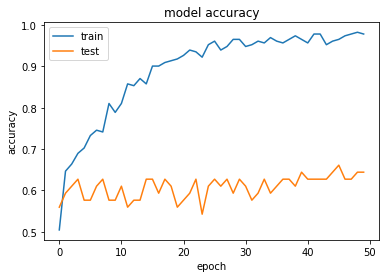

In [ ]:
# summarize history for accuracy
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Model 2
Activation = relu  
No Dropout

In [ ]:
model = K.models.Sequential()
model.add(K.layers.Conv2D(95, (1, 1), activation='relu', input_shape=train_x.shape[1:]))
# model.add(K.layers.Conv2D(50, (1, 1), activation='relu', input_shape=train_x.shape[1:]))
# model.add(K.layers.MaxPooling2D((2, 2)))
model.add(K.layers.Flatten())
model.add(K.layers.Dense(30, activation= 'relu'))
# model.add(K.layers.Dropout(0.15))
model.add(K.layers.Dense(2,activation='relu'))

In [ ]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 2, 2, 95)          9120      
_________________________________________________________________
flatten_14 (Flatten)         (None, 380)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 30)                11430     
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 62        
Total params: 20,612
Trainable params: 20,612
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0003, decay=1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy',
        metrics=['accuracy'])

h2 = model.fit(train_x, train_y, epochs=50, batch_size=4,
      validation_data=(test_x, test_y))

Epoch 1/50
58/58 [==============================] - 1s 7ms/step - loss: 1.0703 - accuracy: 0.4009 - val_loss: 0.9763 - val_accuracy: 0.4068
Epoch 2/50
58/58 [==============================] - 0s 4ms/step - loss: 0.6823 - accuracy: 0.5733 - val_loss: 0.9540 - val_accuracy: 0.5424
Epoch 3/50
58/58 [==============================] - 0s 4ms/step - loss: 0.6430 - accuracy: 0.6681 - val_loss: 0.9276 - val_accuracy: 0.5593
Epoch 4/50
58/58 [==============================] - 0s 4ms/step - loss: 0.6139 - accuracy: 0.6724 - val_loss: 1.1759 - val_accuracy: 0.5763
Epoch 5/50
58/58 [==============================] - 0s 4ms/step - loss: 0.5986 - accuracy: 0.6983 - val_loss: 0.9076 - val_accuracy: 0.5763
Epoch 6/50
58/58 [==============================] - 0s 4ms/step - loss: 0.7436 - accuracy: 0.7155 - val_loss: 1.9017 - val_accuracy: 0.6102
Epoch 7/50
58/58 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.7328 - val_loss: 0.9086 - val_accuracy: 0.6271
Epoch 8/50
58/58 [=====

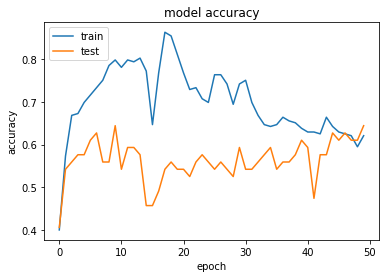

In [ ]:
# summarize history for accuracy
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()